# Importing libraries and classes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from Utils import Utils

from sklearn.ensemble import RandomForestRegressor as SKLearnRandomForestRegressor
from sklearn.tree import DecisionTreeRegressor as SKLearnDecisionTreeRegressor
from sklearn.linear_model import LinearRegression as SKLearnLinearRegression

from DecisionTreeRegressor import DecisionTreeRegressor
from RandomForestRegressor import RandomForestRegressor
from LinearRegression import LinearRegression

# Reading and splitting the data

In [2]:
df = pd.read_csv('./NSO_Population_Sex_dataset/NSO_POPULATION_DATA_CLEANED.csv')

feature_cols = ['District', 'Sex', 'Year', 'Population_Growth_Rate','Average_Population']
X = pd.get_dummies(df[feature_cols], columns=['District', 'Sex'])
y = df["Population"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Custom Implementations - Decision Tree, Random Forest, Linear Regression

In [3]:
# Decision Tree Regressor
Custom_Decision_Tree_Regressor = DecisionTreeRegressor(max_depth=100, min_samples_split=2)
Custom_Decision_Tree_Regressor.fit(X_train.values, y_train.values)
Custom_Decision_Tree_Regressor_Prediction = Custom_Decision_Tree_Regressor.predict(X_test.values)
Custom_Decision_Tree_Regressor_Prediction_MAE = mean_absolute_error(y_test, Custom_Decision_Tree_Regressor_Prediction)
Custom_Decision_Tree_Regressor_Prediction_MSE = mean_squared_error(y_test, Custom_Decision_Tree_Regressor_Prediction)
Custom_Decision_Tree_Regressor_Prediction_RMSE = Utils.root_mean_squared_error(y_test, Custom_Decision_Tree_Regressor_Prediction)
Custom_Decision_Tree_Regressor_Prediction_R2 = r2_score(y_test, Custom_Decision_Tree_Regressor_Prediction)


# Random Forest Regressor
Custom_Random_Forest_Regressor = RandomForestRegressor(n_estimators=100, max_depth=100)
Custom_Random_Forest_Regressor.fit(X_train, y_train)
Custom_Random_Forest_Regressor_Prediction = Custom_Random_Forest_Regressor.predict(X_test)
Custom_Random_Forest_Regressor_MAE = mean_absolute_error(y_test, Custom_Random_Forest_Regressor_Prediction)
Custom_Random_Forest_Regressor_MSE = mean_squared_error(y_test, Custom_Random_Forest_Regressor_Prediction)
Custom_Random_Forest_Regressor_RMSE = Utils.root_mean_squared_error(y_test, Custom_Random_Forest_Regressor_Prediction)
Custom_Random_Forest_Regressor_R2 = r2_score(y_test, Custom_Random_Forest_Regressor_Prediction)

# Linear Regression
Custom_Linear_Regression = LinearRegression(learning_rate=0.01, num_iterations=1000)
Custom_Linear_Regression.fit(X_train, y_train)
Custom_Linear_Regression_Prediction = Custom_Linear_Regression.predict(X_test)
Custom_Linear_Regression_MAE = mean_absolute_error(y_test, Custom_Linear_Regression_Prediction)
Custom_Linear_Regression_MSE = mean_squared_error(y_test, Custom_Linear_Regression_Prediction)
Custom_Linear_Regression_RMSE = Utils.root_mean_squared_error(y_test, Custom_Linear_Regression_Prediction)
Custom_Linear_Regression_R2 = r2_score(y_test, Custom_Linear_Regression_Prediction)

# SKLearn Implementations - Decision Tree, Custom Random Forest using SKLearn Decision Trees, Random Forest, Linear Regression

In [4]:
# SKLearn Decision Tree Regressor
SKLearn_Decision_Tree_Regressor = SKLearnDecisionTreeRegressor(max_depth=100, min_samples_split=2, min_samples_leaf=5)
SKLearn_Decision_Tree_Regressor.fit(X_train, y_train)
SKLearn_Decision_Tree_Regressor_Prediction = SKLearn_Decision_Tree_Regressor.predict(X_test)
SKLearn_Decision_Tree_Regressor_Prediction_MAE = mean_absolute_error(y_test, SKLearn_Decision_Tree_Regressor_Prediction)
SKLearn_Decision_Tree_Regressor_Prediction_MSE = mean_squared_error(y_test, SKLearn_Decision_Tree_Regressor_Prediction)
SKLearn_Decision_Tree_Regressor_Prediction_RMSE = Utils.root_mean_squared_error(y_test, SKLearn_Decision_Tree_Regressor_Prediction)
SKLearn_Decision_Tree_Regressor_Prediction_R2 = r2_score(y_test, SKLearn_Decision_Tree_Regressor_Prediction)

# Custom Random Forest Regressor using SKLearn Decision Trees
SKLearn_Decision_Trees_Random_Forest_Regressor = RandomForestRegressor(n_estimators=100, max_depth=None, custom=False)
SKLearn_Decision_Trees_Random_Forest_Regressor.fit(X_train, y_train)
SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction = SKLearn_Decision_Trees_Random_Forest_Regressor.predict(X_test)
SKLearn_Decision_Trees_Random_Forest_Regressor_MAE = mean_absolute_error(y_test, SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction)
SKLearn_Decision_Trees_Random_Forest_Regressor_MSE = mean_squared_error(y_test, SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction)
SKLearn_Decision_Trees_Random_Forest_Regressor_RMSE = Utils.root_mean_squared_error(y_test, SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction)
SKLearn_Decision_Trees_Random_Forest_Regressor_R2 = r2_score(y_test, SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction)

# SKLearn Random Forest Regressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
SKLearn_Random_Forest_Regressor = SKLearnRandomForestRegressor()
SKLearn_Random_Forest_Regressor.fit(X_train, y_train)
SKLearn_Random_Forest_Regressor_Prediction = SKLearn_Random_Forest_Regressor.predict(X_test)
SKLearn_Random_Forest_Regressor_Prediction_MAE = mean_absolute_error(y_test, SKLearn_Random_Forest_Regressor_Prediction)
SKLearn_Random_Forest_Regressor_Prediction_MSE = mean_squared_error(y_test, SKLearn_Random_Forest_Regressor_Prediction)
SKLearn_Random_Forest_Regressor_Prediction_RMSE = Utils.root_mean_squared_error(y_test, SKLearn_Random_Forest_Regressor_Prediction)
SKLearn_Random_Forest_Regressor_Prediction_R2 = r2_score(y_test, SKLearn_Random_Forest_Regressor_Prediction)

# SKLearn Linear Regression 
SKLearn_Linear_Regression = SKLearnLinearRegression()
SKLearn_Linear_Regression.fit(X_train, y_train)
SKLearn_Linear_Regression_Prediction = SKLearn_Linear_Regression.predict(X_test)
SKLearn_Linear_Regression_MAE = mean_absolute_error(y_test, SKLearn_Linear_Regression_Prediction)
SKLearn_Linear_Regression_MSE = mean_squared_error(y_test, SKLearn_Linear_Regression_Prediction)
SKLearn_Linear_Regression_RMSE = Utils.root_mean_squared_error(y_test, SKLearn_Linear_Regression_Prediction)
SKLearn_Linear_Regression_R2 = r2_score(y_test, SKLearn_Linear_Regression_Prediction)

# Scatter Plots - Actual vs Predicted values

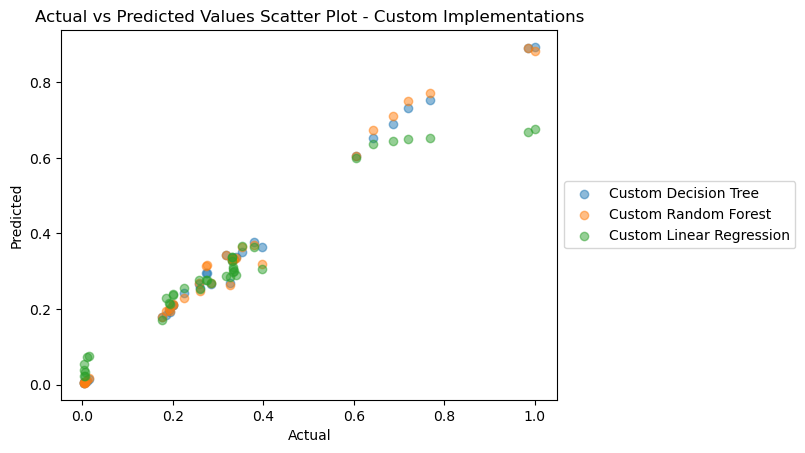

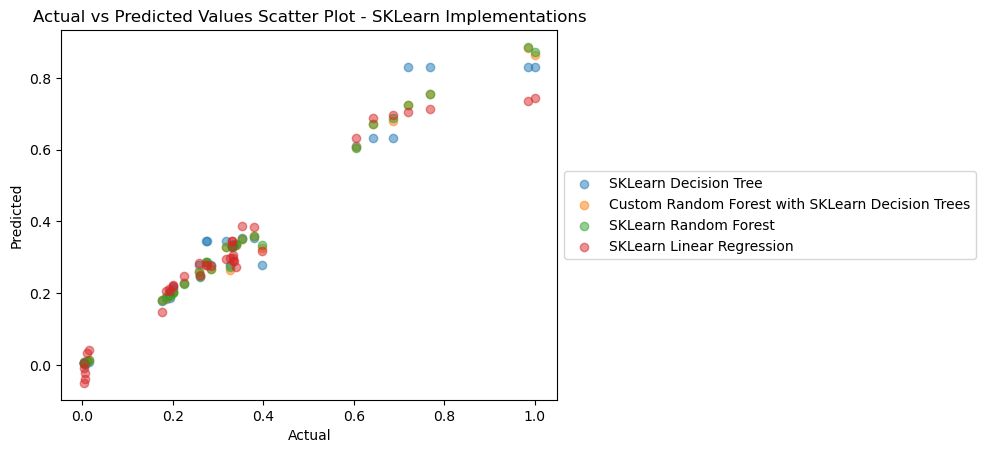

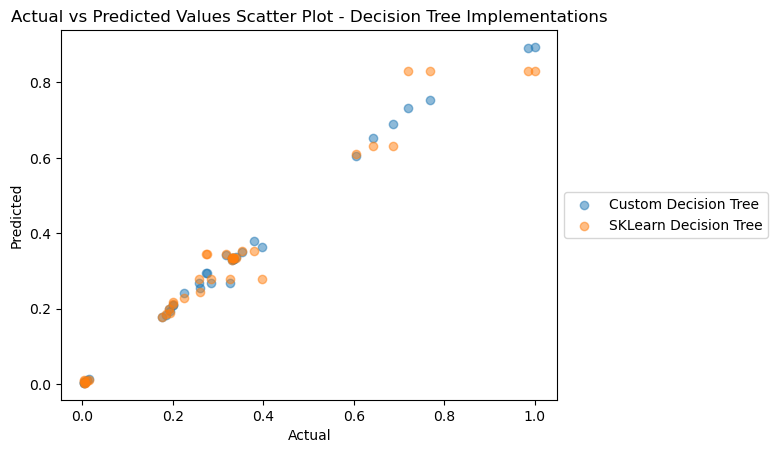

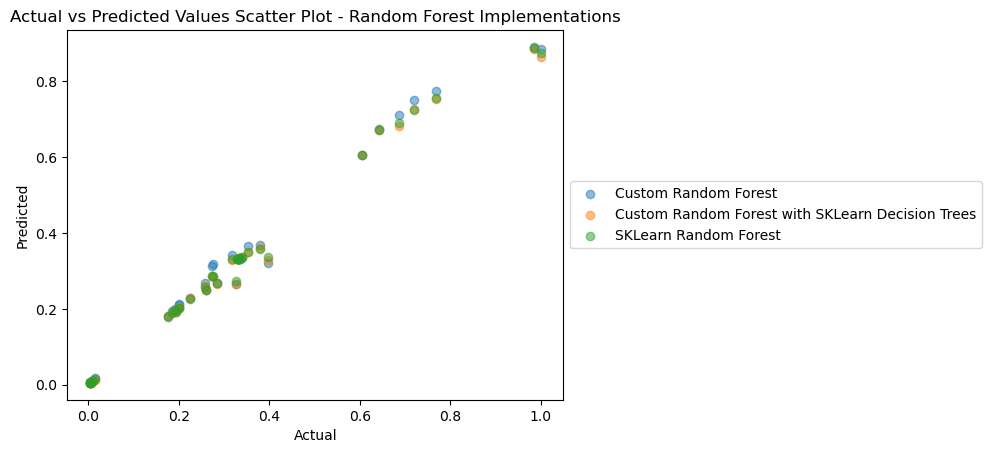

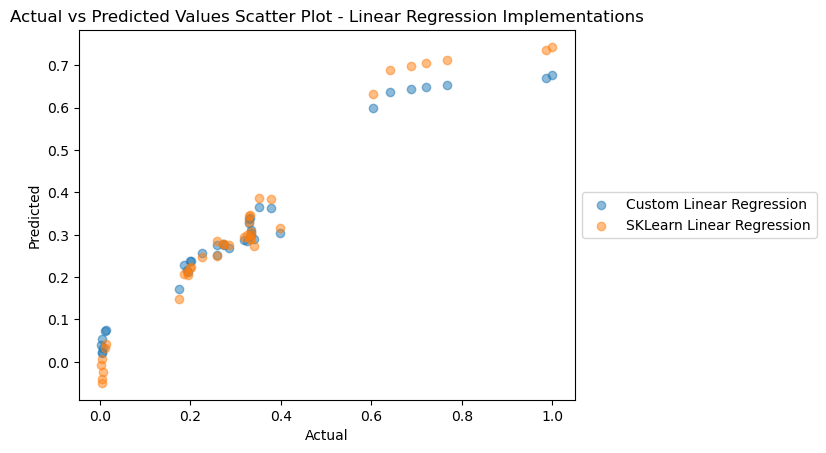

In [5]:
# Custom Decision Tree vs Custom Random Forest vs Custom Linear Regression
plt.scatter(y_test, Custom_Decision_Tree_Regressor_Prediction, alpha=0.5)
plt.scatter(y_test, Custom_Random_Forest_Regressor_Prediction, alpha=0.5)
plt.scatter(y_test, Custom_Linear_Regression_Prediction, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values Scatter Plot - Custom Implementations')
plt.legend(['Custom Decision Tree', 'Custom Random Forest', 'Custom Linear Regression'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# SKLearn Decision Tree vs SKLearn Random Forest vs SKLearn Linear Regression
plt.scatter(y_test, SKLearn_Decision_Tree_Regressor_Prediction, alpha=0.5)
plt.scatter(y_test, SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction, alpha=0.5)
plt.scatter(y_test, SKLearn_Random_Forest_Regressor_Prediction, alpha=0.5)
plt.scatter(y_test, SKLearn_Linear_Regression_Prediction, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values Scatter Plot - SKLearn Implementations')
plt.legend(['SKLearn Decision Tree', 'Custom Random Forest with SKLearn Decision Trees', 'SKLearn Random Forest', 'SKLearn Linear Regression'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Custom vs SKLearn Decision Tree
plt.scatter(y_test, Custom_Decision_Tree_Regressor_Prediction, alpha=0.5)
plt.scatter(y_test, SKLearn_Decision_Tree_Regressor_Prediction, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values Scatter Plot - Decision Tree Implementations')
plt.legend(['Custom Decision Tree', 'SKLearn Decision Tree'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Custom vs SKLearn Random Forest
plt.scatter(y_test, Custom_Random_Forest_Regressor_Prediction, alpha=0.5)
plt.scatter(y_test, SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction, alpha=0.5)
plt.scatter(y_test, SKLearn_Random_Forest_Regressor_Prediction, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values Scatter Plot - Random Forest Implementations')
plt.legend(['Custom Random Forest', 'Custom Random Forest with SKLearn Decision Trees', 'SKLearn Random Forest'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Custom vs SKLearn Linear Regression
plt.scatter(y_test, Custom_Linear_Regression_Prediction, alpha=0.5)
plt.scatter(y_test, SKLearn_Linear_Regression_Prediction, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values Scatter Plot - Linear Regression Implementations')
plt.legend(['Custom Linear Regression', 'SKLearn Linear Regression'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Line Plots - Actual vs Predicted values

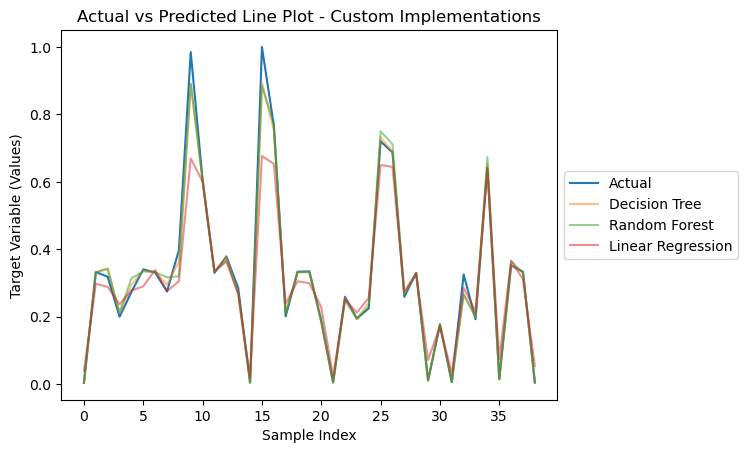

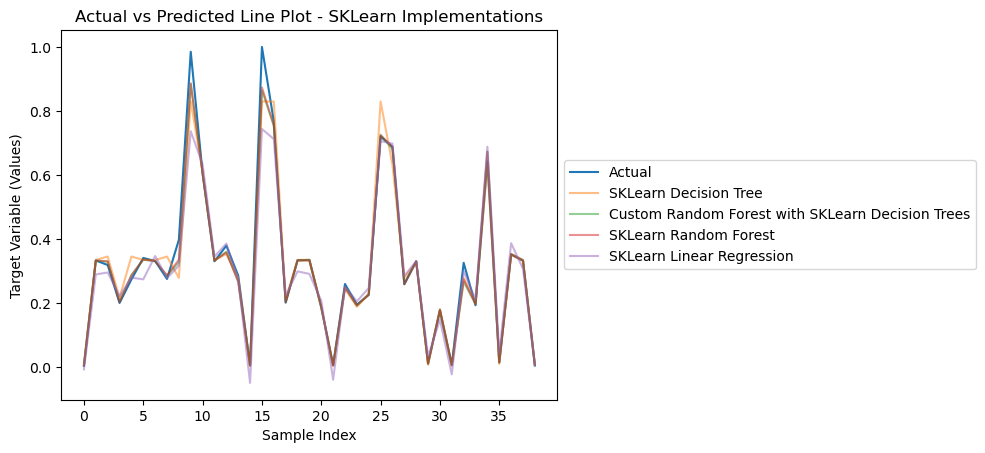

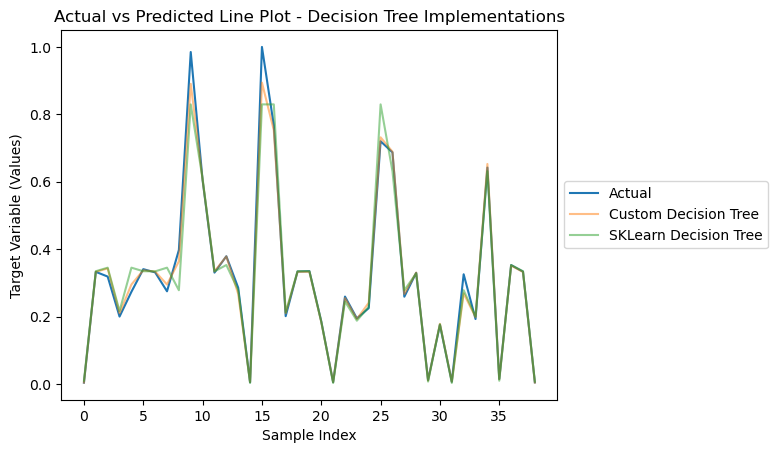

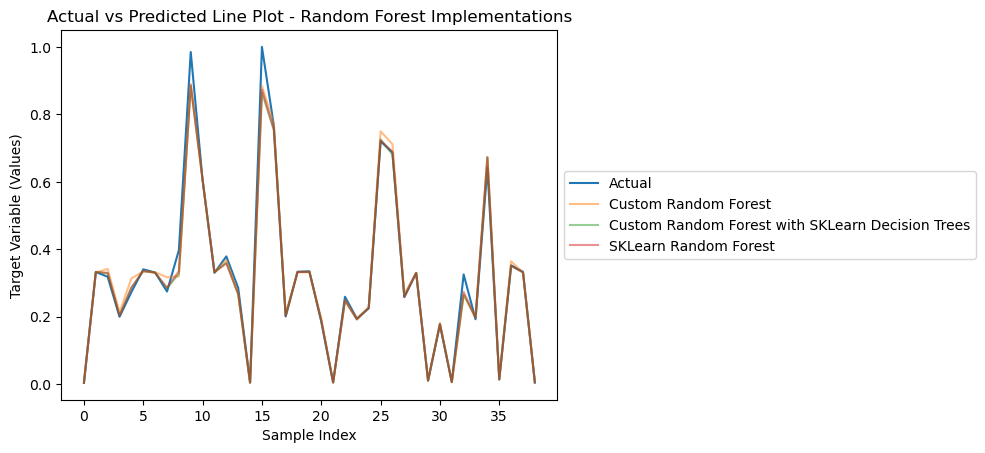

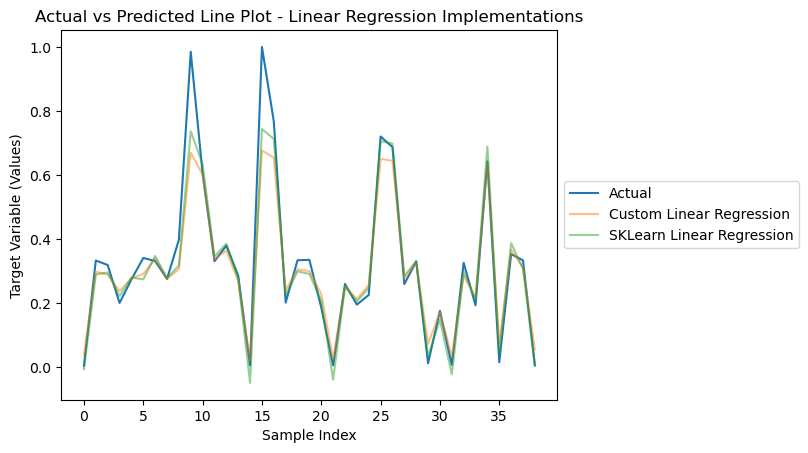

In [6]:
# Custom Decision Tree vs Custom Random Forest vs Custom Linear Regression
plt.plot(y_test.values, label='Actual')
plt.plot(Custom_Decision_Tree_Regressor_Prediction, label='Decision Tree', alpha=0.5)
plt.plot(Custom_Random_Forest_Regressor_Prediction, label='Random Forest', alpha=0.5)
plt.plot(Custom_Linear_Regression_Prediction, label='Linear Regression', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Target Variable (Values)')
plt.title('Actual vs Predicted Line Plot - Custom Implementations')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# SKLearn Decision Tree vs SKLearn Random Forest vs SKLearn Linear Regression
plt.plot(y_test.values, label='Actual')
plt.plot(SKLearn_Decision_Tree_Regressor_Prediction, label='SKLearn Decision Tree', alpha=0.5)
plt.plot(SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction, label='Custom Random Forest with SKLearn Decision Trees', alpha=0.5)
plt.plot(SKLearn_Random_Forest_Regressor_Prediction, label='SKLearn Random Forest', alpha=0.5)
plt.plot(SKLearn_Linear_Regression_Prediction, label='SKLearn Linear Regression', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Target Variable (Values)')
plt.title('Actual vs Predicted Line Plot - SKLearn Implementations')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Custom vs SKLearn Decision Tree
plt.plot(y_test.values, label='Actual')
plt.plot(Custom_Decision_Tree_Regressor_Prediction, label='Custom Decision Tree', alpha=0.5)
plt.plot(SKLearn_Decision_Tree_Regressor_Prediction, label='SKLearn Decision Tree', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Target Variable (Values)')
plt.title('Actual vs Predicted Line Plot - Decision Tree Implementations')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Custom vs SKLearn Random Forest
plt.plot(y_test.values, label='Actual')
plt.plot(Custom_Random_Forest_Regressor_Prediction, label='Custom Random Forest', alpha=0.5)
plt.plot(SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction, label='Custom Random Forest with SKLearn Decision Trees', alpha=0.5)
plt.plot(SKLearn_Random_Forest_Regressor_Prediction, label='SKLearn Random Forest', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Target Variable (Values)')
plt.title('Actual vs Predicted Line Plot - Random Forest Implementations')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Custom vs SKLearn Linear Regression
plt.plot(y_test.values, label='Actual')
plt.plot(Custom_Linear_Regression_Prediction, label='Custom Linear Regression', alpha=0.5)
plt.plot(SKLearn_Linear_Regression_Prediction, label='SKLearn Linear Regression', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Target Variable (Values)')
plt.title('Actual vs Predicted Line Plot - Linear Regression Implementations')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Residual Plots

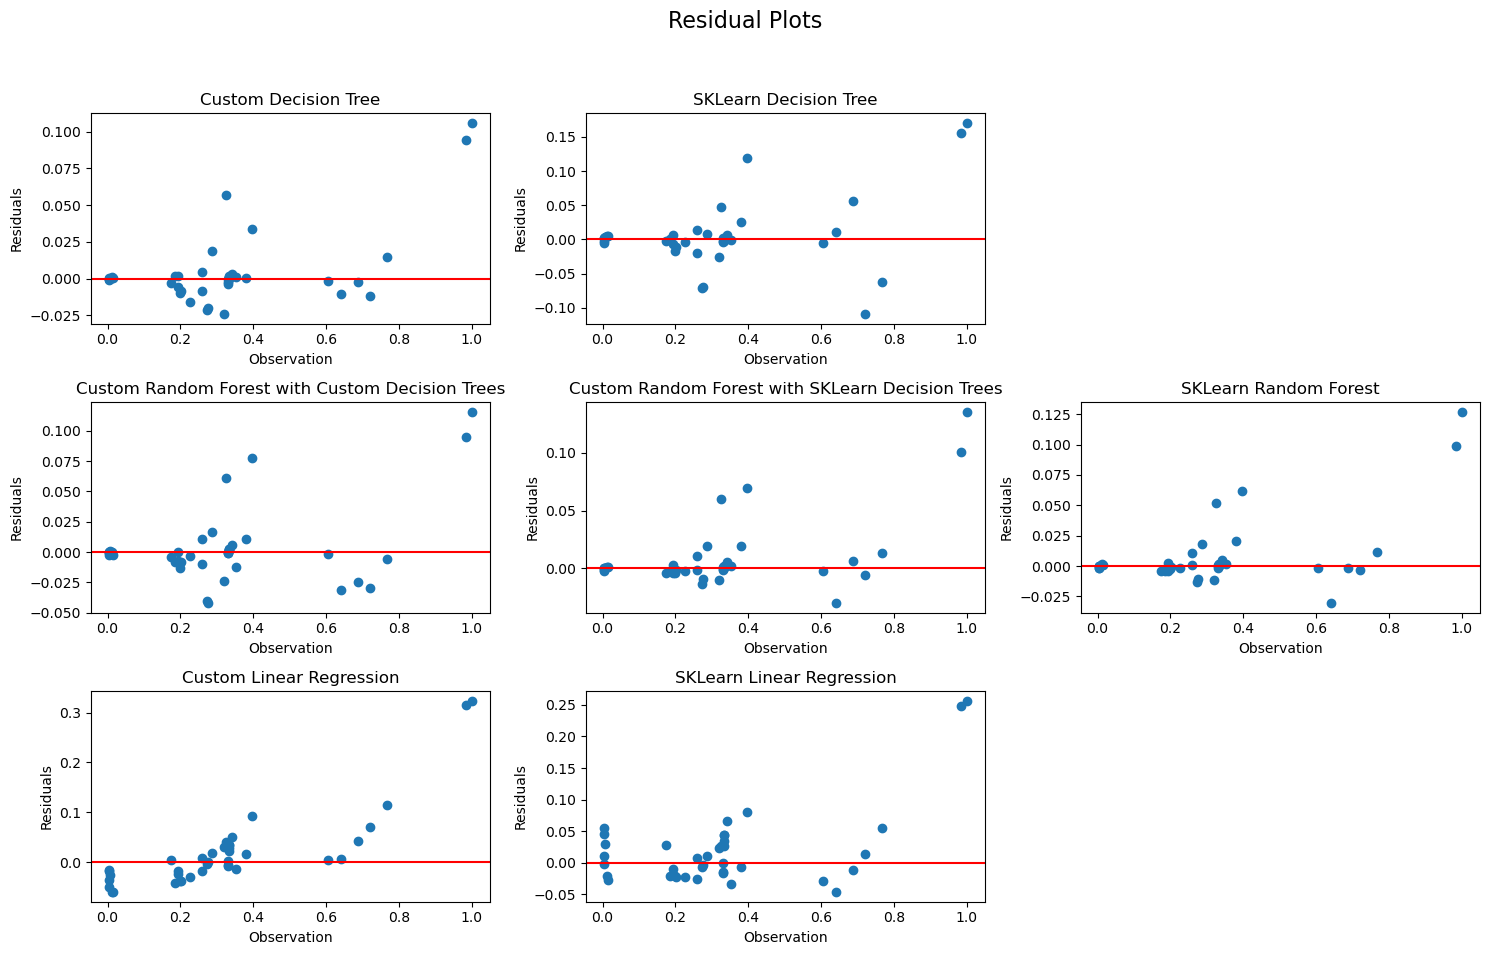

In [7]:
sklearn_decision_tree_regression_residulas = y_test - SKLearn_Decision_Tree_Regressor_Prediction
custom_decision_tree_residuals = y_test - Custom_Decision_Tree_Regressor_Prediction
sklearn_random_forest_residuals = y_test - SKLearn_Random_Forest_Regressor_Prediction
sklearn_decision_trees_random_forest_residuals = y_test - SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction
custom_random_forest_residuals = y_test - Custom_Random_Forest_Regressor_Prediction
sklearn_Linear_regression_residuals = y_test - SKLearn_Linear_Regression_Prediction
custom_Linear_regression_residuals = y_test - Custom_Linear_Regression_Prediction

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.8, top=0.9)

axes[0,0].scatter(y_test, custom_decision_tree_residuals)
axes[0,0].axhline(y=0, color='r', linestyle='-')
axes[0,0].set_title('Custom Decision Tree')

axes[0,1].scatter(y_test, sklearn_decision_tree_regression_residulas)
axes[0,1].axhline(y=0, color='r', linestyle='-')
axes[0,1].set_title('SKLearn Decision Tree')

axes[1,0].scatter(y_test, custom_random_forest_residuals)
axes[1,0].axhline(y=0, color='r', linestyle='-')
axes[1,0].set_title('Custom Random Forest with Custom Decision Trees')

axes[1,1].scatter(y_test, sklearn_decision_trees_random_forest_residuals)
axes[1,1].axhline(y=0, color='r', linestyle='-')
axes[1,1].set_title('Custom Random Forest with SKLearn Decision Trees')

axes[1,2].scatter(y_test, sklearn_random_forest_residuals)
axes[1,2].axhline(y=0, color='r', linestyle='-')
axes[1,2].set_title('SKLearn Random Forest')

axes[2,0].scatter(y_test, custom_Linear_regression_residuals)
axes[2,0].axhline(y=0, color='r', linestyle='-')
axes[2,0].set_title('Custom Linear Regression')

axes[2,1].scatter(y_test, sklearn_Linear_regression_residuals)
axes[2,1].axhline(y=0, color='r', linestyle='-')
axes[2,1].set_title('SKLearn Linear Regression')

axes[0,2].set_axis_off()
axes[2,2].set_axis_off()

for ax in axes.flat:
    ax.set(xlabel='Observation', ylabel='Residuals')

plt.suptitle('Residual Plots', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the title
plt.show()

# Mean Absolute Error, Mean Squared Error, Root Mean Squared Error, R Squared

In [8]:
table_data = {
    '': ['Custom Decision Tree Regressor', 'Custom Random Forest Regressor', 'Custom Linear Regression', 'SKLearn Decision Tree Regressor', 'Custom Random Forest Regressor using SKLearn Decision Trees', 'SKLearn Random Forest Regressor', 'SKLearn Linear Regression'],
    'Mean Absolute Error (MAE)': [Custom_Decision_Tree_Regressor_Prediction_MAE, Custom_Random_Forest_Regressor_MAE, Custom_Linear_Regression_MAE, SKLearn_Decision_Tree_Regressor_Prediction_MAE, SKLearn_Decision_Trees_Random_Forest_Regressor_MAE, SKLearn_Random_Forest_Regressor_Prediction_MAE,SKLearn_Linear_Regression_MAE],
    'Mean Squared Error (MSE)': [Custom_Decision_Tree_Regressor_Prediction_MSE, Custom_Random_Forest_Regressor_MSE, Custom_Linear_Regression_MSE, SKLearn_Decision_Tree_Regressor_Prediction_MSE, SKLearn_Decision_Trees_Random_Forest_Regressor_MSE, SKLearn_Random_Forest_Regressor_Prediction_MSE, SKLearn_Linear_Regression_MSE],
    'Root Mean Squared Error (RMSE)': [Custom_Decision_Tree_Regressor_Prediction_RMSE, Custom_Random_Forest_Regressor_RMSE, Custom_Linear_Regression_RMSE, SKLearn_Decision_Tree_Regressor_Prediction_RMSE, SKLearn_Decision_Trees_Random_Forest_Regressor_RMSE, SKLearn_Random_Forest_Regressor_Prediction_RMSE, SKLearn_Linear_Regression_RMSE],
    'R Squared (R\u00b2)': [Custom_Decision_Tree_Regressor_Prediction_R2, Custom_Random_Forest_Regressor_R2, Custom_Linear_Regression_R2, SKLearn_Decision_Tree_Regressor_Prediction_R2, SKLearn_Decision_Trees_Random_Forest_Regressor_R2, SKLearn_Random_Forest_Regressor_Prediction_R2, SKLearn_Linear_Regression_R2]
}

print(tabulate(table_data, headers='keys', tablefmt='fancy_grid'))

╒═════════════════════════════════════════════════════════════╤═════════════════════════════╤════════════════════════════╤══════════════════════════════════╤══════════════════╕
│                                                             │   Mean Absolute Error (MAE) │   Mean Squared Error (MSE) │   Root Mean Squared Error (RMSE) │   R Squared (R²) │
╞═════════════════════════════════════════════════════════════╪═════════════════════════════╪════════════════════════════╪══════════════════════════════════╪══════════════════╡
│ Custom Decision Tree Regressor                              │                   0.0126726 │                0.000700957 │                        0.0264756 │         0.988613 │
├─────────────────────────────────────────────────────────────┼─────────────────────────────┼────────────────────────────┼──────────────────────────────────┼──────────────────┤
│ Custom Random Forest Regressor                              │                   0.0173635 │                0.0010

# Actual vs Predicted Values

In [16]:
results_table_data = {
    'Actual Values': y_test,
    'Custom Decision Tree Regressor': Custom_Decision_Tree_Regressor_Prediction,
    'Custom Random Forest Regressor': Custom_Random_Forest_Regressor_Prediction,
    'Custom Linear Regression': Custom_Linear_Regression_Prediction,
    'SKLearn Decision Tree Regressor': SKLearn_Decision_Tree_Regressor_Prediction,
    'Custom Random Forest Regressor using SKLearn Decision Trees': SKLearn_Decision_Trees_Random_Forest_Regressor_Prediction,
    'SKLearn Random Forest Regressor': SKLearn_Random_Forest_Regressor_Prediction,
    'SKLearn Linear Regressor': SKLearn_Linear_Regression_Prediction
}

print(tabulate(results_table_data, headers='keys', tablefmt='fancy_grid'))

╒═════════════════╤══════════════════════════════════╤══════════════════════════════════╤════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════════════════════════════════╤═══════════════════════════════════╤════════════════════════════╕
│   Actual Values │   Custom Decision Tree Regressor │   Custom Random Forest Regressor │   Custom Linear Regression │   SKLearn Decision Tree Regressor │   Custom Random Forest Regressor using SKLearn Decision Trees │   SKLearn Random Forest Regressor │   SKLearn Linear Regressor │
╞═════════════════╪══════════════════════════════════╪══════════════════════════════════╪════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════════════════════════════════╪═══════════════════════════════════╪════════════════════════════╡
│      0.00389466 │                       0.0042304  │                       0.00505902 │                  0.0394561 │                        0.0096